In [49]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(parallel)
library(introdataviz)

# deg

In [50]:
levels='L3'
file_list<-list.files(path = paste0("/home//jupyter/BRI_Analysis/scRNA/Analysis-Cross-Sectional/02B_DESeq2_BR1_VS_BR2_",'L3'), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [51]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [52]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.1 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

# cv


In [53]:
cell_counts<-read.csv('/home//jupyter/BRI_Analysis/scRNA/cell_counts_BRI.csv',check.names = FALSE)
celltypes<-colnames(cell_counts)[3:73]

In [54]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data<-meta_data %>% filter(Covid_exlcusion=='no')

In [55]:
meta<-unique(meta_data[c('subject.subjectGuid','CMV.IgG.Serology.Result.Interpretation','subject.biologicalSex','cohort.cohortGuid')])

In [56]:
colnames(meta)<-c('donor','CMV','Sex','cohort.cohortGuid')

In [57]:
cell_counts<-left_join(meta_data,cell_counts)

Joining with `by = join_by(pbmc_sample_id)`


In [58]:
CV_Res_FILES<-list.files(path = "01A_CV_all_timepoint_nonY2D90/", pattern = "csv", all.files = TRUE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = TRUE, include.dirs = TRUE, no.. = FALSE)

In [59]:
CV_Res_meta<-as.data.frame(CV_Res_FILES)

In [60]:
CV_Res_meta<-CV_Res_meta %>%
  mutate(    after_slash = str_extract(CV_Res_FILES, "(?<=//).+"),
    donor = str_extract(CV_Res_FILES, "(?<=//)[^_]+"),
    celltype = str_extract(after_slash, "(?<=_)[^.]+(?=\\.csv)") )%>%
  select(-after_slash)

In [61]:
CV_Res_meta<-left_join(CV_Res_meta,meta)

Joining with `by = join_by(donor)`


In [62]:
counts_df_minCell <- data.frame()  

for (i in celltypes) {
cell_counts_subset<-cell_counts[c('pbmc_sample_id',i)]
pbmc_sample_id_filtered<-cell_counts_subset[cell_counts_subset[i]>10,]$pbmc_sample_id      
    meta_data_subset <- meta_data %>% filter(pbmc_sample_id %in% pbmc_sample_id_filtered)

    # Check if meta_data_subset is empty
    if (nrow(meta_data_subset) == 0) {
        next  # Skip to the next iteration if no data
    }

    sample_counts <- as.data.frame(table(meta_data_subset$subject.subjectGuid))
    sample_counts$celltypes <- i
    
    colnames(sample_counts) <- c('donor', 'number_of_timepoint_with_minCell', 'celltypes')
    counts_df_minCell <- rbind.fill(counts_df_minCell, sample_counts)
}
counts_df_minCell$celltypes<-gsub(' ','_',counts_df_minCell$celltypes)

In [63]:

df_list<-mclapply(pull(CV_Res_meta['CV_Res_FILES']),function(x){
df<-read.csv(x) %>% filter(mean>=0.1)
return(df)
},mc.cores=60)


In [64]:
df_all<-do.call(rbind, df_list)
df_all<-left_join(df_all,meta)

Joining with `by = join_by(donor)`


In [65]:
df_all<-left_join(df_all,counts_df_minCell)

Joining with `by = join_by(celltypes, donor)`


In [66]:
# filter out samples does not contian 4 time point and genes has zero expression in any of 4 time point

df_all<-df_all %>% filter(number_of_timepoint>6,number_of_timepoint_non_zero_expr>6,number_of_timepoint_with_minCell>6)#%>%


In [67]:
df=as.data.frame(table(df_all$X,df_all$celltypes,df_all$cohort.cohortGuid))
colnames(df)<-c('X',"celltypes",'cohort.cohortGuid','donor_counts')

In [68]:
df_all_averge<-df_all %>% group_by(celltypes,X,cohort.cohortGuid) %>%   
                    dplyr::summarise(cv_average = mean(cv),
                                     mean_average = mean(mean),
                                    variance_average = mean(variance),
                                    sd_average = mean(sd),) 

`summarise()` has grouped output by 'celltypes', 'X'. You can override using
the `.groups` argument.


In [69]:
# filter gene by at least 10 donor in each cohorts

df_all_averge<-left_join(df_all_averge,df)
df_all_averge<-df_all_averge %>%
  group_by(celltypes,X) %>%
  filter(all(donor_counts > 10)) %>%
  ungroup()

Joining with `by = join_by(celltypes, X, cohort.cohortGuid)`


In [70]:
selected_celltype<-as.data.frame(table(df_all_averge$celltypes,df_all_averge$cohort.cohortGuid)) %>%
  group_by(Var1) %>%
  filter(all(Freq > 1000)) %>%
  ungroup()

In [71]:
DEG<-DEG[c('celltype','X','Expression')]
colnames(DEG)[1]<-'celltypes'
DEG$celltypes<-gsub(" ",'_',DEG$celltypes)

In [72]:
df_all_averge<-left_join(df_all_averge,DEG)

Joining with `by = join_by(celltypes, X)`


In [73]:
df_all_averge<-df_all_averge[!is.na(df_all_averge$Expression),]

In [74]:
selected_celltype<-as.data.frame(table(df_all_averge$celltypes,df_all_averge$Expression))

In [75]:
selected_celltype<-selected_celltype %>% filter(Freq>100)%>%
  group_by(Var1) %>%
  filter(n() >= 2) %>%
  ungroup()

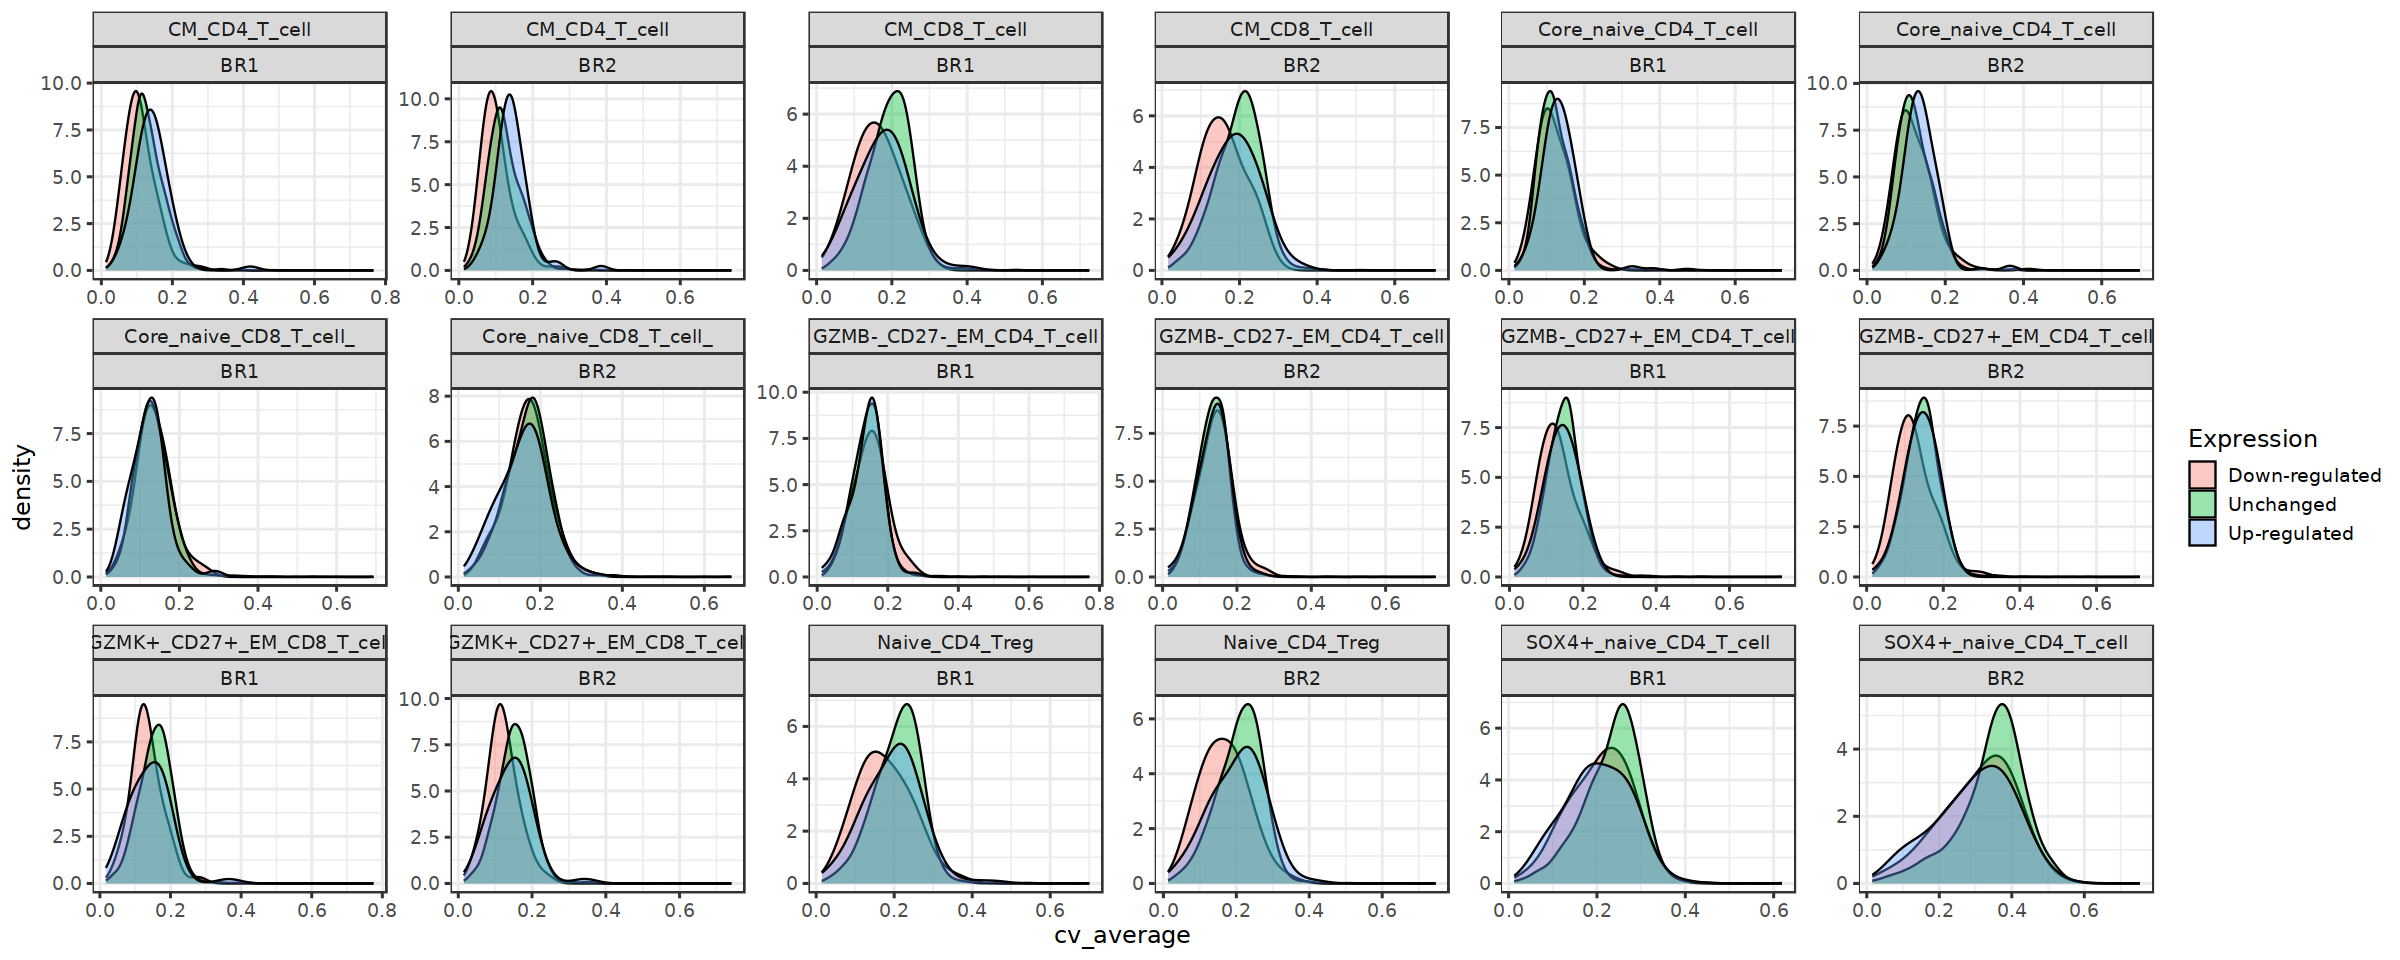

In [76]:
options(repr.plot.width = 20, repr.plot.height = 8)
P<-ggplot(data=df_all_averge[!is.na(df_all_averge$Expression),]%>% filter (celltypes %in% selected_celltype$Var1), aes(x=cv_average,group=Expression, fill=Expression)) +
   geom_density(adjust=1.5, alpha=.4) +
   theme_bw(base_size=14)+facet_wrap(~celltypes+cohort.cohortGuid,ncol=6,scale='free')
P
